Using device: cuda
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3753852.54it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 139379.49it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 525014.96it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]
c:\Users\user\anaconda3\envs\TrendFlow\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\TrendFlow\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Query Image Label: 5
Top similar images:


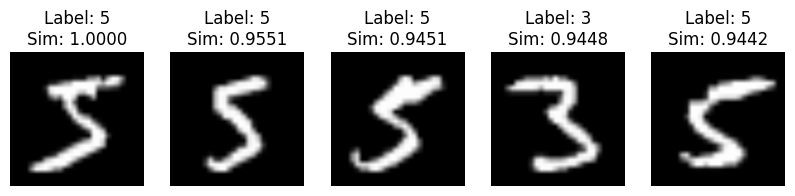

In [5]:
# Google Colab 환경에서 PyTorch 및 관련 라이브러리 설치

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# GPU가 사용 가능한지 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. 데이터 준비
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 배치 크기를 줄여 메모리 사용량 줄이기
batch_size = 32  # 메모리 부족 문제 발생 시 배치 크기를 더 줄일 수 있음
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 2. 특징 추출을 위한 모델 생성 (ResNet18 사용)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # 마지막 FC layer 제거

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return x

# 모델을 GPU로 이동 (가능한 경우)
model = FeatureExtractor().to(device)
model.eval()

# 3. 특징 벡터 생성
feature_vectors = []
image_labels = []
images = []  # 이미지를 저장하여 나중에 시각화에 사용

# 메모리 부족 문제를 해결하기 위해 torch.no_grad()를 사용하여 역전파 비활성화
with torch.no_grad():
    for imgs, labels in data_loader:
        imgs = imgs.to(device)  # 데이터를 GPU로 이동
        imgs = imgs.repeat(1, 3, 1, 1)  # MNIST 이미지를 3채널로 변환
        features = model(imgs)
        feature_vectors.extend(features.cpu().numpy())  # GPU에서 CPU로 이동 후 numpy 변환
        image_labels.extend(labels.cpu().numpy())  # 레이블도 CPU로 이동
        images.extend(imgs.cpu().numpy())  # 이미지도 CPU로 이동

# numpy 배열로 변환
feature_vectors = np.array(feature_vectors)
images = np.array(images)

# 4. 유사도 계산 (코사인 유사도 사용)
def get_similar_images(query_vector, feature_vectors, top_k=5):
    similarities = cosine_similarity(query_vector.reshape(1, -1), feature_vectors)[0]
    indices = similarities.argsort()[-top_k:][::-1]
    return indices, similarities[indices]

# 5. 추천 시스템 구현
query_index = 0
query_vector = feature_vectors[query_index]

similar_indices, similarities = get_similar_images(query_vector, feature_vectors)

# 6. 결과 시각화
def show_images(indices, similarities, images, labels):
    plt.figure(figsize=(10, 2))
    for i, (index, similarity) in enumerate(zip(indices, similarities)):
        ax = plt.subplot(1, len(indices), i+1)
        plt.imshow(np.transpose(images[index], (1, 2, 0)))
        plt.title(f"Label: {labels[index]}\nSim: {similarity:.4f}")
        plt.axis('off')
    plt.show()

print(f"Query Image Label: {image_labels[query_index]}")
print("Top similar images:")
show_images(similar_indices, similarities, images, image_labels)
